## Import Required Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import urllib.request
import seaborn as sns
from sklearn.metrics import mean_squared_error

## Question 4: SVD Image Compression 

### Download the image

In [14]:
# Download the image
url = "https://cdn-uploads.piazza.com/paste/lzgqhnhklws43d/396d946449a4bb3b07d84946cccaaf4bd718ab26f8a233af9fcf4d3310a983a5/tulips.jpeg"

try:
    # Method 1: Using urllib
    with urllib.request.urlopen(url) as response:
        image_data = response.read()
    image = Image.open(BytesIO(image_data))
    print("Image downloaded successfully using urllib")
except:
    try:
        # Method 2: Using requests
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        print("Image downloaded successfully using requests")
    except:
        print("Could not download image. Please check the URL or internet connection.")
        # Create a synthetic image for demonstration
        image = Image.fromarray(np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8))
        print("Using synthetic image for demonstration")

print(f"Image size: {image.size}")
print(f"Image mode: {image.mode}")

Image downloaded successfully using urllib
Image size: (225, 225)
Image mode: RGB


### Compute SVD manually by hand without SVD Function

In [15]:
def compute_svd_manual(A):
    """Compute SVD manually without using np.linalg.svd"""
    # Compute A^T * A
    AtA = A.T @ A
    
    # Compute eigenvalues and eigenvectors of A^T * A
    eigenvalues, V = np.linalg.eig(AtA)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]
    
    # Compute singular values
    singular_values = np.sqrt(np.abs(eigenvalues))
    
    # Compute U matrix
    U = np.zeros((A.shape[0], A.shape[0]))
    for i in range(min(A.shape[0], A.shape[1])):
        if singular_values[i] > 1e-10:  # Avoid division by zero
            U[:, i] = (A @ V[:, i]) / singular_values[i]
        else:
            # For zero singular values, use a unit vector orthogonal to others
            U[:, i] = np.random.randn(A.shape[0])
            for j in range(i):
                U[:, i] -= np.dot(U[:, i], U[:, j]) * U[:, j]
            U[:, i] /= np.linalg.norm(U[:, i])
    
    # Fill remaining columns of U with orthonormal vectors
    if A.shape[0] > A.shape[1]:
        for i in range(A.shape[1], A.shape[0]):
            U[:, i] = np.random.randn(A.shape[0])
            for j in range(i):
                U[:, i] -= np.dot(U[:, i], U[:, j]) * U[:, j]
            U[:, i] /= np.linalg.norm(U[:, i])
    
    return U, singular_values, V.T

### COmpute SVD Compression manually by hand without SVD Function

In [16]:
def compute_svd_compression(image_array, k):
    """Compute SVD compression for a 2D array"""
    U, s, Vt = compute_svd_manual(image_array)
    
    # Reconstruct using top k singular values
    Uk = U[:, :k]
    sk = s[:k]
    Vtk = Vt[:k, :]
    
    reconstructed = Uk @ np.diag(sk) @ Vtk
    
    # Ensure values are in valid range
    reconstructed = np.clip(reconstructed, 0, 255)
    
    return reconstructed, s

def calculate_compression_ratio(m, n, k):
    """Calculate compression ratio for given dimensions and k"""
    original_storage = m * n
    compressed_storage = k * (m + n + 1)
    return original_storage / compressed_storage

def calculate_variance_explained(singular_values, k):
    """Calculate percentage of variance explained by top k singular values"""
    total_variance = np.sum(singular_values**2)
    explained_variance = np.sum(singular_values[:k]**2)
    return (explained_variance / total_variance) * 100

def calculate_reconstruction_error(singular_values, k):
    """Calculate reconstruction error using Frobenius norm"""
    remaining_energy = np.sum(singular_values[k:]**2)
    return np.sqrt(remaining_energy)

### Part (a): Single Channel Compression


PART (a): Single Channel Compression
Grayscale image dimensions: 225 x 225
Rank of image matrix: 225

Computing reconstruction for k = 5

Computing reconstruction for k = 10

Computing reconstruction for k = 20

Computing reconstruction for k = 50

Computing reconstruction for k = 100


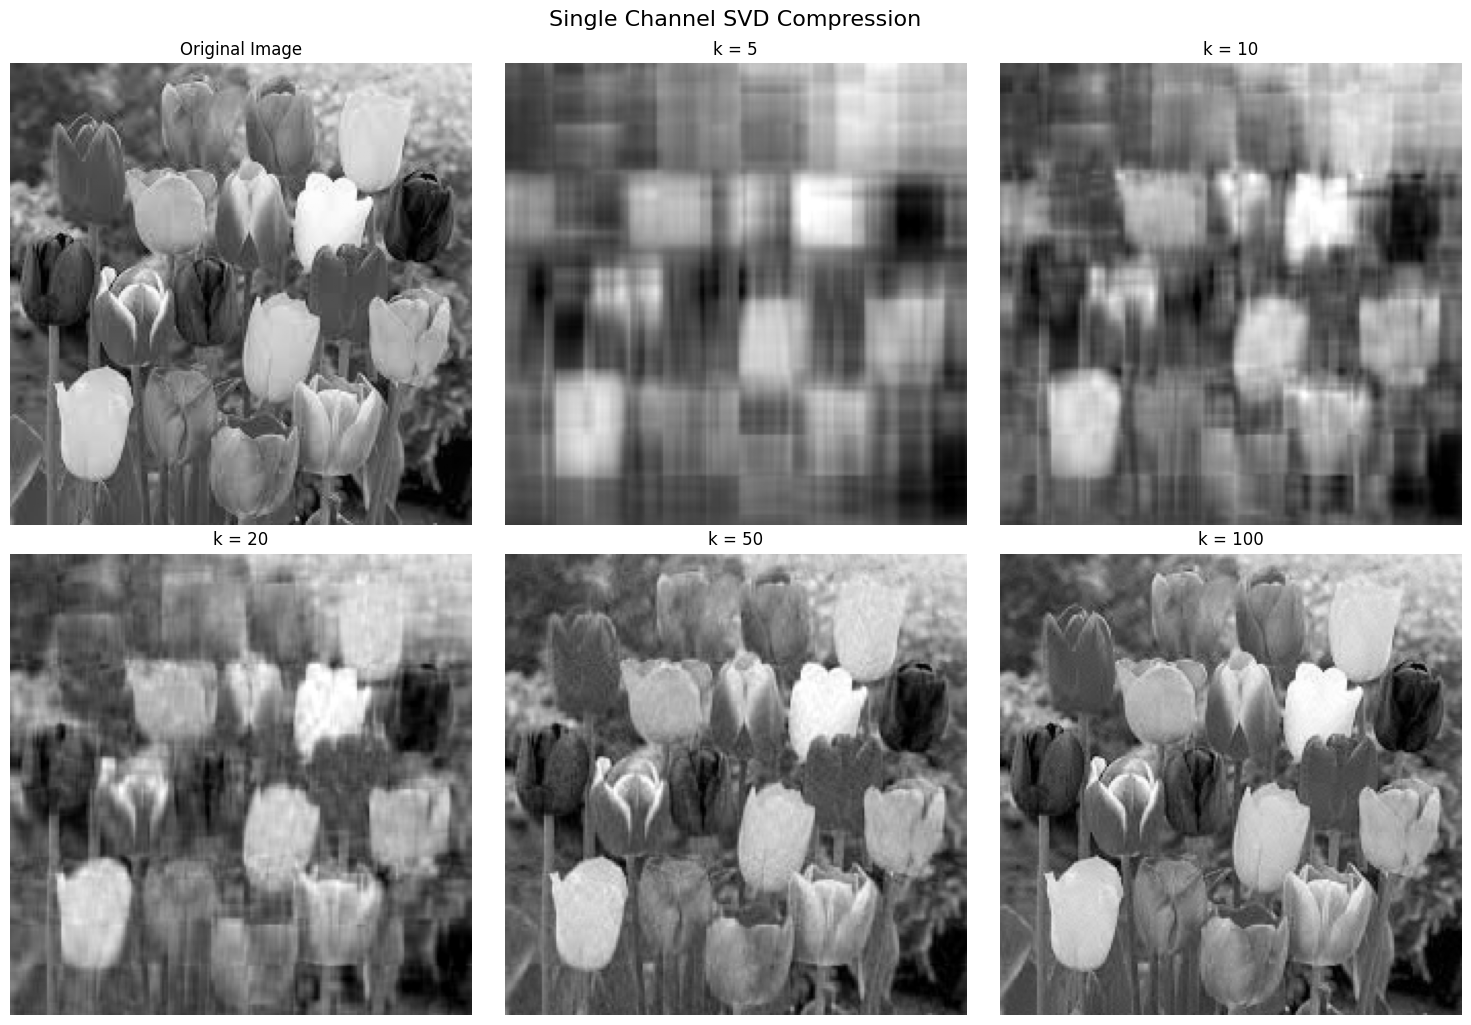

In [17]:
# Part (a): Single Channel Compression
print("\n" + "="*50)
print("PART (a): Single Channel Compression")
print("="*50)

# Convert to grayscale if color
if image.mode == 'RGB':
    grayscale_image = image.convert('L')
else:
    grayscale_image = image

# Convert to numpy array
image_array = np.array(grayscale_image, dtype=np.float64)
m, n = image_array.shape
print(f"Grayscale image dimensions: {m} x {n}")

# Compute full SVD manually
U_full, s_full, Vt_full = compute_svd_manual(image_array)
r = len(s_full)
print(f"Rank of image matrix: {r}")

# Values of k to test
k_values = [5, 10, 20, 50, 100]
reconstructed_images = []

# Create figure for part (a)
plt.figure(figsize=(15, 10))

# Plot original image
plt.subplot(2, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Reconstruct and plot for each k
for i, k in enumerate(k_values):
    print(f"\nComputing reconstruction for k = {k}")
    
    # Reconstruct using top k singular values
    Uk = U_full[:, :k]
    sk = s_full[:k]
    Vtk = Vt_full[:k, :]
    reconstructed = Uk @ np.diag(sk) @ Vtk
    reconstructed = np.clip(reconstructed, 0, 255)
    reconstructed_images.append(reconstructed)
    
    # Plot reconstructed image
    plt.subplot(2, 3, i+2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f'k = {k}')
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Single Channel SVD Compression', fontsize=16, y=1.02)
plt.show()

### Calculate metrics

In [18]:
for i, k in enumerate(k_values):
    print(f"\nComputing reconstruction for k = {k}")
    # Calculate metrics
    compression_ratio = calculate_compression_ratio(m, n, k)
    variance_explained = calculate_variance_explained(s_full, k)
    reconstruction_error = calculate_reconstruction_error(s_full, k)
    
    print(f"  Compression ratio: {compression_ratio:.2f}:1")
    print(f"  Variance explained: {variance_explained:.2f}%")
    print(f"  Reconstruction error: {reconstruction_error:.2f}")


Computing reconstruction for k = 5
  Compression ratio: 22.45:1
  Variance explained: 96.13%
  Reconstruction error: 5813.31

Computing reconstruction for k = 10
  Compression ratio: 11.23:1
  Variance explained: 97.89%
  Reconstruction error: 4295.54

Computing reconstruction for k = 20
  Compression ratio: 5.61:1
  Variance explained: 98.91%
  Reconstruction error: 3086.53

Computing reconstruction for k = 50
  Compression ratio: 2.25:1
  Variance explained: 99.70%
  Reconstruction error: 1616.09

Computing reconstruction for k = 100
  Compression ratio: 1.12:1
  Variance explained: 99.95%
  Reconstruction error: 649.66


### Part (b): Compression Ratio Analysis

In [19]:
# Part (b): Compression Ratio Analysis
print("\n" + "="*50)
print("PART (b): Compression Ratio Analysis")
print("="*50)

# Create table of results
print("\nCompression Analysis Table:")
print("k\tCompression Ratio\tVariance Explained (%)")
print("-" * 50)

compression_ratios = []
variances_explained = []

for k in k_values:
    compression_ratio = calculate_compression_ratio(m, n, k)
    variance_explained = calculate_variance_explained(s_full, k)
    
    compression_ratios.append(compression_ratio)
    variances_explained.append(variance_explained)
    
    print(f"{k}\t{compression_ratio:.2f}:1\t\t{variance_explained:.2f}%")

# Find k for compression ratio >= 10:1
target_ratio = 10
k_target = (m * n) / (target_ratio * (m + n + 1))
print(f"\nFor compression ratio ≥ {target_ratio}:1, need k ≤ {k_target:.1f}")
print(f"So choose k ≤ {int(k_target)}")


PART (b): Compression Ratio Analysis

Compression Analysis Table:
k	Compression Ratio	Variance Explained (%)
--------------------------------------------------
5	22.45:1		96.13%
10	11.23:1		97.89%
20	5.61:1		98.91%
50	2.25:1		99.70%
100	1.12:1		99.95%

For compression ratio ≥ 10:1, need k ≤ 11.2
So choose k ≤ 11


### Part (c): Reconstruction Error


PART (c): Reconstruction Error Analysis
k = 5: Reconstruction Error = 5813.31
k = 10: Reconstruction Error = 4295.54
k = 20: Reconstruction Error = 3086.53
k = 50: Reconstruction Error = 1616.09
k = 100: Reconstruction Error = 649.66


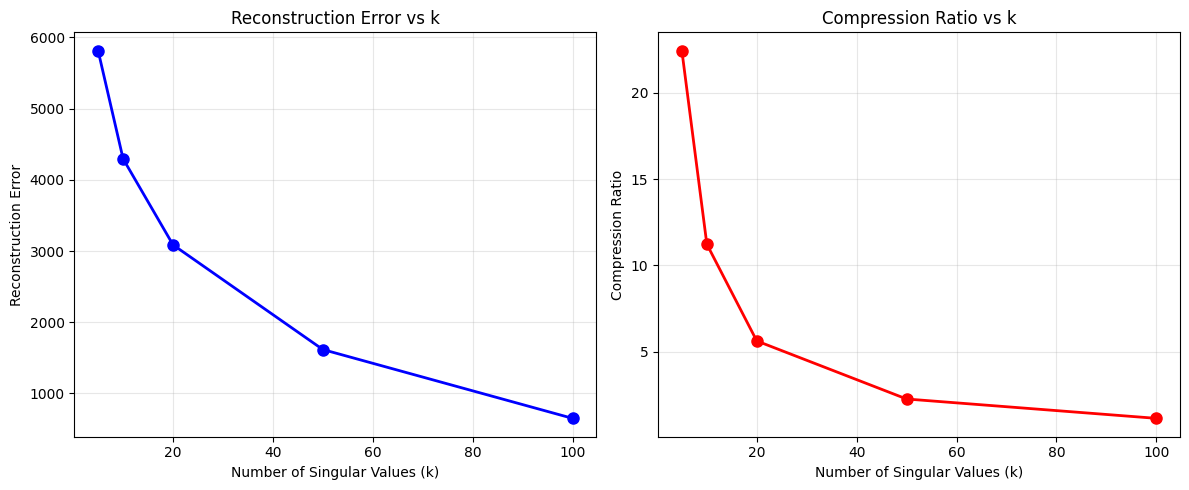


Trade-off Analysis:
- High compression (low k): Small storage, fast transmission, but poor image quality
- Low compression (high k): Excellent image quality, but large storage, slow transmission
- Optimal k depends on application requirements


In [20]:
# Part (c): Reconstruction Error
print("\n" + "="*50)
print("PART (c): Reconstruction Error Analysis")
print("="*50)

# Calculate reconstruction errors
reconstruction_errors = []
for k in k_values:
    error = calculate_reconstruction_error(s_full, k)
    reconstruction_errors.append(error)
    print(f"k = {k}: Reconstruction Error = {error:.2f}")

# Create plots for part (c)
plt.figure(figsize=(12, 5))

# Subplot 1: Reconstruction error vs k
plt.subplot(1, 2, 1)
plt.plot(k_values, reconstruction_errors, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Singular Values (k)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs k')
plt.grid(True, alpha=0.3)

# Subplot 2: Compression ratio vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, compression_ratios, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Singular Values (k)')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTrade-off Analysis:")
print("- High compression (low k): Small storage, fast transmission, but poor image quality")
print("- Low compression (high k): Excellent image quality, but large storage, slow transmission")
print("- Optimal k depends on application requirements")

In [21]:
# Part (d): Color Image Compression
print("\n" + "="*50)
print("PART (d): Color Image Compression")
print("="*50)

# Load color image
if image.mode != 'RGB':
    print("Input image is not RGB. Using grayscale image for color demonstration.")
    # Create a synthetic color image
    color_image_array = np.stack([image_array, image_array, image_array], axis=2)
else:
    color_image_array = np.array(image, dtype=np.float64)

print(f"Color image shape: {color_image_array.shape}")

# Split into RGB channels
r_channel = color_image_array[:, :, 0]
g_channel = color_image_array[:, :, 1] 
b_channel = color_image_array[:, :, 2]

m_color, n_color, _ = color_image_array.shape
k_color = 20

print(f"Compressing each channel with k = {k_color}")

# Compress each channel
r_compressed, s_r = compute_svd_compression(r_channel, k_color)
g_compressed, s_g = compute_svd_compression(g_channel, k_color)
b_compressed, s_b = compute_svd_compression(b_channel, k_color)

# Merge compressed channels
color_compressed = np.stack([r_compressed, g_compressed, b_compressed], axis=2)
color_compressed = np.clip(color_compressed, 0, 255).astype(np.uint8)

# Calculate overall compression ratio
original_storage_color = 3 * m_color * n_color
compressed_storage_color = 3 * k_color * (m_color + n_color + 1)
compression_ratio_color = calculate_compression_ratio(m_color, n_color, k_color)

print(f"Original storage (color): {original_storage_color} elements")
print(f"Compressed storage (color): {compressed_storage_color} elements")
print(f"Compression ratio (color): {compression_ratio_color:.2f}:1")



PART (d): Color Image Compression
Color image shape: (225, 225, 3)
Compressing each channel with k = 20
Original storage (color): 151875 elements
Compressed storage (color): 27060 elements
Compression ratio (color): 5.61:1


### Display original and compressed color images

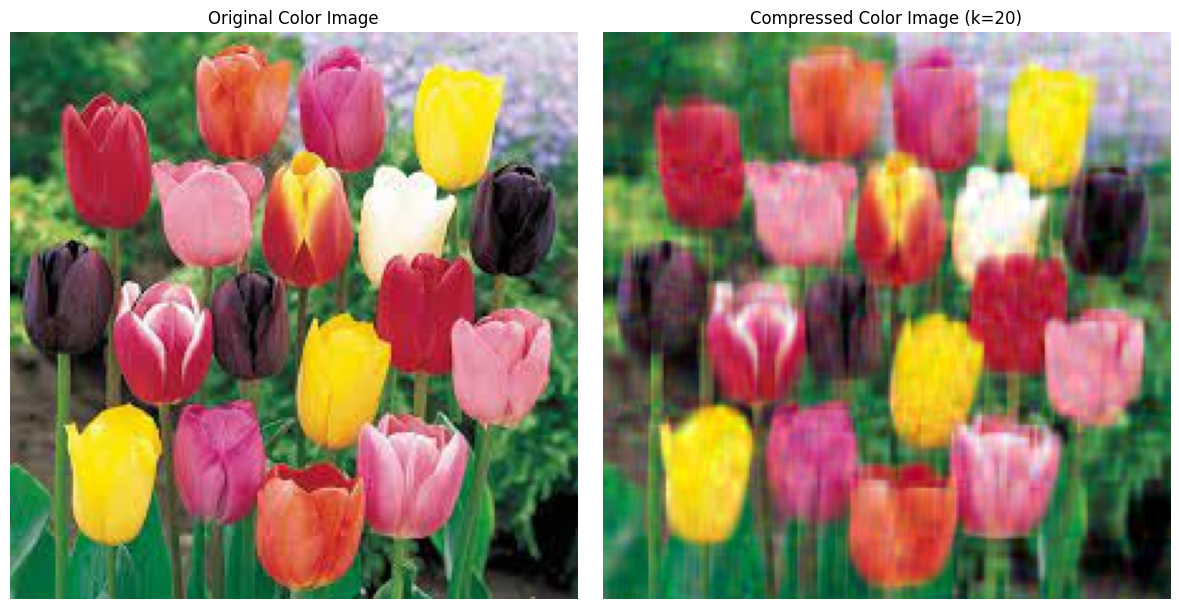

In [22]:
# Display original and compressed color images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
if image.mode == 'RGB':
    plt.imshow(color_image_array.astype(np.uint8))
else:
    plt.imshow(color_image_array.astype(np.uint8))
plt.title('Original Color Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(color_compressed)
plt.title(f'Compressed Color Image (k={k_color})')
plt.axis('off')
plt.tight_layout()
plt.show()

### Additional analysis: Singular value distribution

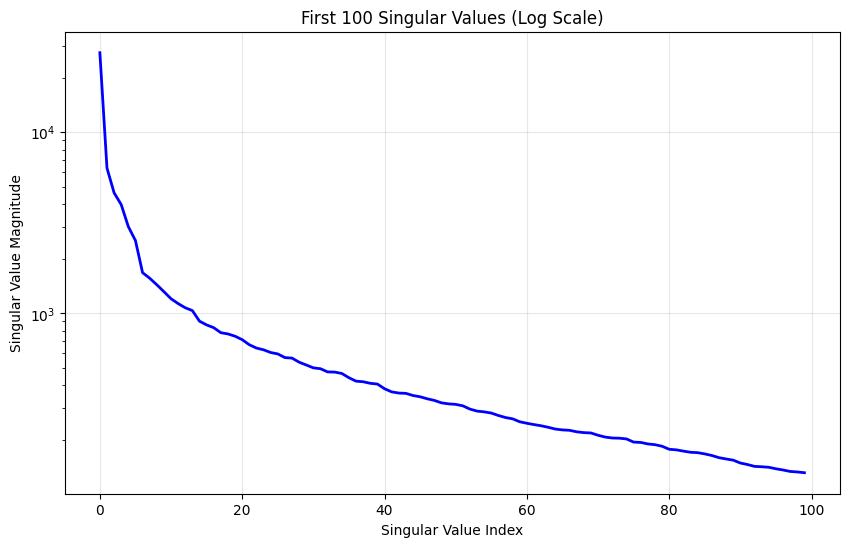


SUMMARY
Observations from SVD image compression:
1. Most visual information is captured in the first few singular values
2. Compression ratio decreases as k increases
3. Image quality improves rapidly with initial k values, then plateaus
4. SVD provides a principled way to trade off quality vs file size
5. Color images can be compressed channel-wise with similar ratios

Final Compression Results:
k	Gray Ratio	Color Ratio	Variance Expl.
-------------------------------------------------------
5	22.45:1		22.45:1		96.13%
10	11.23:1		11.23:1		97.89%
20	5.61:1		5.61:1		98.91%
50	2.25:1		2.25:1		99.70%
100	1.12:1		1.12:1		99.95%


In [23]:
# Additional analysis: Singular value distribution
plt.figure(figsize=(10, 6))
plt.plot(s_full[:100], 'b-', linewidth=2)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.title('First 100 Singular Values (Log Scale)')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print("Observations from SVD image compression:")
print("1. Most visual information is captured in the first few singular values")
print("2. Compression ratio decreases as k increases")
print("3. Image quality improves rapidly with initial k values, then plateaus")
print("4. SVD provides a principled way to trade off quality vs file size")
print("5. Color images can be compressed channel-wise with similar ratios")

# Print final compression results table
print("\nFinal Compression Results:")
print("k\tGray Ratio\tColor Ratio\tVariance Expl.")
print("-" * 55)
for i, k in enumerate(k_values):
    gray_ratio = compression_ratios[i]
    color_ratio = calculate_compression_ratio(m, n, k)  # Same as gray for same dimensions
    variance = variances_explained[i]
    print(f"{k}\t{gray_ratio:.2f}:1\t\t{color_ratio:.2f}:1\t\t{variance:.2f}%")